# Regression Analysis on News Documents
In this notebook, we include all the regression analysis we did using the output of Coh-metrix on a collection of fake and real news documents.

In [2]:
# reading the excel file which includes all the information
library("readxl")
my_data <- read_excel("data/FakeNewsNet/processed/fakenewsnet_full.xlsx")
head(my_data)

X__1,DESSC,DESWC,DESPL,DESSL,DESSLd,DESWLsy,DESWLsyd,DESWLlt,DESWLltd,⋯,WRDPOLc,WRDHYPn,WRDHYPv,WRDHYPnv,RDFRE,RDFKGL,RDL2,label,shares,id
0,76,1714,76,22.974,10.418,1.510,0.869,4.582,2.609,⋯,3.772,5.763,1.508,1.715,56.198,11.024,12.892,0,1.579784,100
1,12,263,12,22.500,19.691,1.578,0.957,4.852,2.559,⋯,3.898,5.067,1.561,1.635,51.090,11.578,20.088,0,1.716003,101
2,11,247,11,22.727,14.914,1.490,0.821,4.530,2.662,⋯,4.352,5.290,1.890,1.813,57.989,10.749,10.049,0,1.278754,102
3,7,119,7,17.143,6.986,1.706,0.995,4.908,2.765,⋯,3.654,5.451,1.926,2.151,45.252,11.171,13.503,0,1.924279,103
4,19,432,19,23.105,17.136,1.688,0.920,5.035,2.612,⋯,3.754,5.701,1.718,2.274,40.952,13.196,13.048,0,1.462398,104
5,8,237,8,30.000,22.168,1.662,0.981,5.017,2.833,⋯,3.288,6.264,2.105,2.550,36.160,15.575,9.242,0,2.437751,105


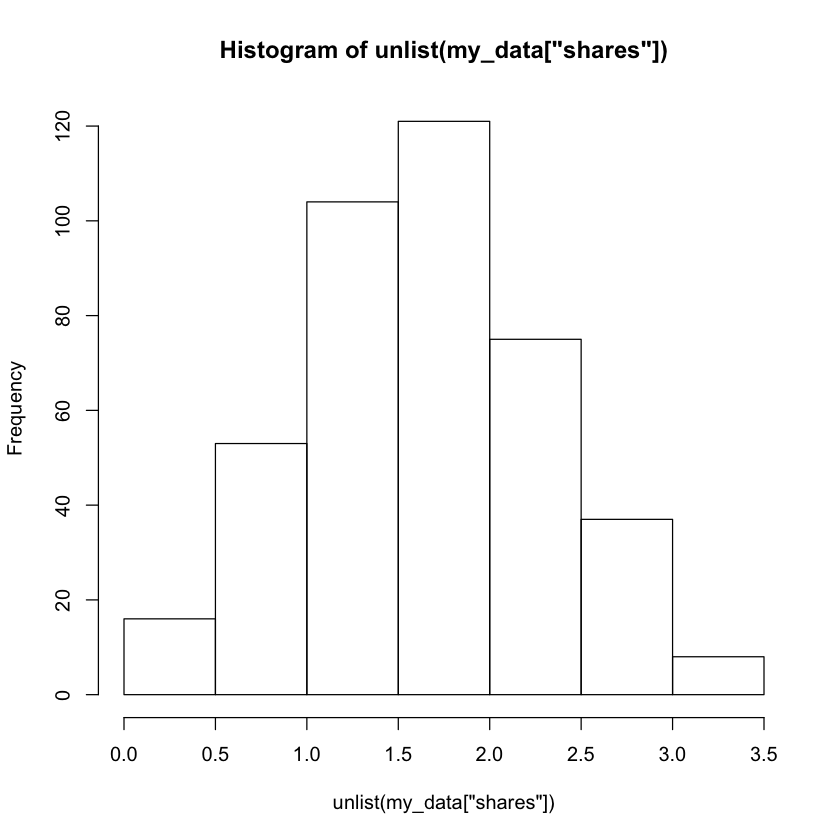

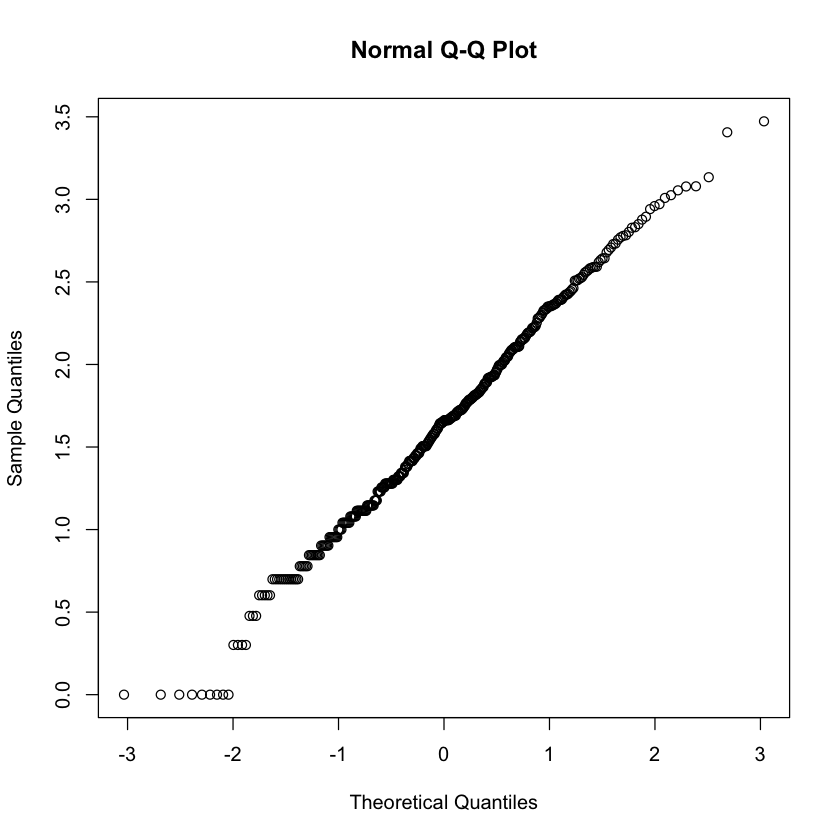

In [3]:
# plotting the normal distribution and probability plot
hist(unlist(my_data["shares"]))
qqnorm(unlist(my_data["shares"]))

## Principal Component Analysis (PCA)
In this section, we first run a PCA on all the indexes we have from the coh-metrix to reduce the number of features. Then, using the scores from the PCA model, we run a linear regression analysis to find the significant components in predicting the number of shares.

In [4]:
# Principal Component Analysis (PCA)
# ----------------------------------
# to install the "psych" package, uncomment the two following lines:
# options(download.file.method = "wget")
# install.packages("psych")
library("psych")

# dropping the columns that we do not want in the regression analysis.
truth_labels <- my_data["label"]
drops <- c("X__1", "id", "DESPL", "label", "shares")
x <- my_data[, !(names(my_data) %in% drops)]
y <- my_data["shares"]

# printing eigenvalues to find the number of components for PCA
# print(eigen(cor(x)))

pca <- psych::principal(x, nfactors=22, rotate="varimax")
# print(pca$loadings, cutoff = 0.4, sort = TRUE)

# linear regression using the PCA scores
lin_model <- lm(unlist(y) ~ pca$scores + as.matrix(truth_labels))
summary(lin_model)


Call:
lm(formula = unlist(y) ~ pca$scores + as.matrix(truth_labels))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.84211 -0.42937  0.01476  0.42498  1.76033 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.4896590  0.0486399  30.626  < 2e-16 ***
pca$scoresRC2            0.0695861  0.0323385   2.152   0.0320 *  
pca$scoresRC1           -0.0285493  0.0323460  -0.883   0.3780    
pca$scoresRC6            0.0067498  0.0320431   0.211   0.8333    
pca$scoresRC5           -0.0245512  0.0321620  -0.763   0.4457    
pca$scoresRC3            0.0001801  0.0324238   0.006   0.9956    
pca$scoresRC4            0.0636687  0.0321395   1.981   0.0483 *  
pca$scoresRC12           0.0692495  0.0321231   2.156   0.0317 *  
pca$scoresRC9           -0.0096707  0.0322394  -0.300   0.7644    
pca$scoresRC16          -0.0336989  0.0321357  -1.049   0.2950    
pca$scoresRC11           0.0255809  0.0321603   0.795   0.4269    
pca$sco

## Cross validation
In this section, we train our linear regression models using three methods of cross validation.

In [15]:
# K-fold cross-validation for linear regression
# ----------------------------------------------
# to install the "caret" package, uncomment the two following lines:
# options(download.file.method = "wget")
# install.packages("caret")
library(caret)

drops <- c("X__1", "id", "DESPL")
x <- my_data[, !(names(my_data) %in% drops)]

set.seed(123)
# three different setup for cross validation
train.control <- trainControl(method = "LOOCV")
# train.control <- trainControl(method = "cv", number = 10)
# train.control <- trainControl(method = "repeatedcv", number = 10)
lin_model <- train(shares ~ ., data=x, method = "lm", trControl = train.control)
print(lin_model)
summary(lin_model)

Linear Regression 

414 samples
104 predictors

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 413, 413, 413, 413, 413, 413, ... 
Resampling results:

  RMSE       Rsquared    MAE     
  0.7260553  0.03504098  0.576029

Tuning parameter 'intercept' was held constant at a value of TRUE



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.52183 -0.36582 -0.03454  0.35224  1.75584 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -9.830e+03  7.252e+03  -1.355 0.176254    
DESSC        8.054e-03  6.964e-03   1.156 0.248414    
DESWC       -2.856e-04  3.180e-04  -0.898 0.369792    
DESSL       -3.718e-02  1.869e+00  -0.020 0.984139    
DESSLd       9.669e-03  1.030e-02   0.939 0.348714    
DESWLsy      3.398e+03  2.308e+03   1.472 0.141967    
DESWLsyd     1.999e+00  1.008e+00   1.983 0.048243 *  
DESWLlt     -8.466e-02  4.432e-01  -0.191 0.848616    
DESWLltd    -8.881e-01  3.054e-01  -2.908 0.003902 ** 
PCNARz       7.486e+01  6.270e+01   1.194 0.233427    
PCNARp       2.036e-02  1.395e-02   1.459 0.145578    
PCSYNz       2.775e+01  6.456e+01   0.430 0.667600    
PCSYNp       5.472e-03  1.248e-02   0.439 0.661283    
PCCNCz      -2.925e+01  5.851e+01  -0.500 0.617490    
PCCNCp    

## Stepwise linear regression
We also did a stepwise backward linear regression to eliminate insignificant features from our model. As it is shown in our results, causal verb and causal particles show up as significant predictors in our linear regression model. 

AIC stands for Akaike information criterion which is an estimator of the relative quality of statistical models for a given set of data. Generally, a lower value for AIC mean a model better. There is a $<none>$ feature listed among the other features in the output. As it can be seen, if we eliminate any feature above $<none>$, the AIC value will be lower which means elimination of that feature is good for our model. And, if we remove any feature below $<none>$, the AIC will be larger which means removing the features below $<none>$ is not good for our model.

### Backward

In [16]:
# Stepwise linear regression - backward
drops <- c("X__1", "id", "DESPL")
x <- my_data[, !(names(my_data) %in% drops)]

# a lower value of AIC suggests "better" model
lin_model <- lm(shares ~ ., data=x)
formula(lin_model)
summary(step(lin_model, direction = "backward"))

shares ~ DESSC + DESWC + DESSL + DESSLd + DESWLsy + DESWLsyd + 
    DESWLlt + DESWLltd + PCNARz + PCNARp + PCSYNz + PCSYNp + 
    PCCNCz + PCCNCp + PCREFz + PCREFp + PCDCz + PCDCp + PCVERBz + 
    PCVERBp + PCCONNz + PCCONNp + PCTEMPz + PCTEMPp + CRFNO1 + 
    CRFAO1 + CRFSO1 + CRFNOa + CRFAOa + CRFSOa + CRFCWO1 + CRFCWO1d + 
    CRFCWOa + CRFCWOad + CRFANP1 + CRFANPa + LSASS1 + LSASS1d + 
    LSASSp + LSASSpd + LSAGN + LSAGNd + LDTTRc + LDTTRa + LDMTLD + 
    LDVOCD + CNCAll + CNCCaus + CNCLogic + CNCADC + CNCTemp + 
    CNCTempx + CNCAdd + CNCPos + CNCNeg + SMCAUSv + SMCAUSvp + 
    SMINTEp + SMCAUSr + SMINTEr + SMCAUSlsa + SMCAUSwn + SMTEMP + 
    SYNLE + SYNNP + SYNMEDpos + SYNMEDwrd + SYNMEDlem + SYNSTRUTa + 
    SYNSTRUTt + DRNP + DRVP + DRAP + DRPP + DRPVAL + DRNEG + 
    DRGERUND + DRINF + WRDNOUN + WRDVERB + WRDADJ + WRDADV + 
    WRDPRO + WRDPRP1s + WRDPRP1p + WRDPRP2 + WRDPRP3s + WRDPRP3p + 
    WRDFRQc + WRDFRQa + WRDFRQmc + WRDAOAc + WRDFAMc + WRDCNCc + 
    WRDIMGc + WRDM

Start:  AIC=-322.18
shares ~ DESSC + DESWC + DESSL + DESSLd + DESWLsy + DESWLsyd + 
    DESWLlt + DESWLltd + PCNARz + PCNARp + PCSYNz + PCSYNp + 
    PCCNCz + PCCNCp + PCREFz + PCREFp + PCDCz + PCDCp + PCVERBz + 
    PCVERBp + PCCONNz + PCCONNp + PCTEMPz + PCTEMPp + CRFNO1 + 
    CRFAO1 + CRFSO1 + CRFNOa + CRFAOa + CRFSOa + CRFCWO1 + CRFCWO1d + 
    CRFCWOa + CRFCWOad + CRFANP1 + CRFANPa + LSASS1 + LSASS1d + 
    LSASSp + LSASSpd + LSAGN + LSAGNd + LDTTRc + LDTTRa + LDMTLD + 
    LDVOCD + CNCAll + CNCCaus + CNCLogic + CNCADC + CNCTemp + 
    CNCTempx + CNCAdd + CNCPos + CNCNeg + SMCAUSv + SMCAUSvp + 
    SMINTEp + SMCAUSr + SMINTEr + SMCAUSlsa + SMCAUSwn + SMTEMP + 
    SYNLE + SYNNP + SYNMEDpos + SYNMEDwrd + SYNMEDlem + SYNSTRUTa + 
    SYNSTRUTt + DRNP + DRVP + DRAP + DRPP + DRPVAL + DRNEG + 
    DRGERUND + DRINF + WRDNOUN + WRDVERB + WRDADJ + WRDADV + 
    WRDPRO + WRDPRP1s + WRDPRP1p + WRDPRP2 + WRDPRP3s + WRDPRP3p + 
    WRDFRQc + WRDFRQa + WRDFRQmc + WRDAOAc + WRDFAMc + WRDCNCc +


Call:
lm(formula = shares ~ DESSC + DESWLsy + DESWLsyd + DESWLltd + 
    PCNARz + PCNARp + PCSYNz + PCCNCz + PCREFz + PCVERBz + PCCONNz + 
    CRFNO1 + CRFAO1 + CRFNOa + CRFAOa + CRFSOa + CRFCWO1 + CRFCWO1d + 
    CRFCWOa + CRFANP1 + LSASS1 + LSASSp + LSAGN + LDTTRc + LDMTLD + 
    LDVOCD + CNCAll + CNCCaus + CNCLogic + CNCADC + CNCAdd + 
    SMCAUSv + SMINTEp + SMCAUSr + SMCAUSlsa + SMCAUSwn + SMTEMP + 
    SYNLE + SYNNP + SYNMEDpos + SYNMEDwrd + SYNMEDlem + DRAP + 
    DRPP + DRPVAL + DRNEG + DRGERUND + WRDNOUN + WRDVERB + WRDADJ + 
    WRDPRO + WRDPRP1s + WRDPRP1p + WRDPRP3s + WRDPRP3p + WRDFRQc + 
    WRDFRQa + WRDFRQmc + WRDFAMc + WRDCNCc + WRDIMGc + WRDMEAc + 
    WRDPOLc + WRDHYPn + WRDHYPnv + RDFRE + RDFKGL + label, data = x)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.47929 -0.34834 -0.01112  0.36829  1.86860 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.152e+04  6.636e+03  -1.737  0.08335 .  
DESSC        2.450e-03  1.

### Forward

In [19]:
# Stepwise linear regression - forward
drops <- c("X__1", "id", "DESPL")
x <- my_data[, !(names(my_data) %in% drops)]

# a lower value of AIC suggests "better" model
fit_start <- lm(shares ~ 1, data=x)
fit_all <- lm(shares ~ ., data=x)
summary(step(fit_start, direction = "forward", scope=formula(fit_all)))

Start:  AIC=-340.26
shares ~ 1

            Df Sum of Sq    RSS     AIC
+ DRPP       1    4.7432 176.37 -349.25
+ DRAP       1    3.5096 177.61 -346.37
+ label      1    3.4228 177.69 -346.16
+ WRDADV     1    2.5769 178.54 -344.20
+ RDFKGL     1    2.5648 178.55 -344.17
+ WRDPRP1p   1    2.4106 178.71 -343.81
+ DESSL      1    2.1422 178.97 -343.19
+ CRFAOa     1    2.0908 179.03 -343.07
+ RDFRE      1    2.0786 179.04 -343.04
+ WRDFAMc    1    2.0068 179.11 -342.88
+ DRNP       1    1.9302 179.19 -342.70
+ CNCTemp    1    1.9042 179.21 -342.64
+ CRFNOa     1    1.8729 179.24 -342.57
+ WRDADJ     1    1.8556 179.26 -342.53
+ PCSYNp     1    1.7002 179.42 -342.17
+ CRFSOa     1    1.6712 179.44 -342.10
+ PCSYNz     1    1.6044 179.51 -341.95
+ WRDPOLc    1    1.4990 179.62 -341.71
+ CRFAO1     1    1.4077 179.71 -341.49
+ WRDPRP3p   1    1.4072 179.71 -341.49
+ WRDFRQc    1    1.3913 179.72 -341.46
+ DRNEG      1    1.3507 179.77 -341.36
+ DESWLsyd   1    1.2092 179.91 -341.04
+ CRFSO1


Call:
lm(formula = shares ~ DRPP + label + DRAP + WRDHYPnv + WRDFAMc + 
    WRDPRP1p + WRDPRP3p + WRDMEAc + CNCTemp + WRDFRQc + DESWLltd + 
    DESWLsyd + WRDPRP2 + DESSC + LDVOCD + WRDHYPn + DRNP + DESSLd + 
    CRFCWO1d + CRFNOa + DESWC, data = x)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6993 -0.4098 -0.0332  0.4208  1.8890 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.6873396  2.6770440   2.498 0.012897 *  
DRPP         0.0056054  0.0020751   2.701 0.007208 ** 
label        0.2632319  0.0671035   3.923 0.000103 ***
DRAP        -0.0128164  0.0030579  -4.191 3.43e-05 ***
WRDHYPnv    -0.7151157  0.1728031  -4.138 4.28e-05 ***
WRDFAMc     -0.0022740  0.0051824  -0.439 0.661060    
WRDPRP1p     0.0107161  0.0037860   2.830 0.004887 ** 
WRDPRP3p    -0.0052146  0.0034244  -1.523 0.128614    
WRDMEAc     -0.0058765  0.0024096  -2.439 0.015179 *  
CNCTemp      0.0069038  0.0038112   1.811 0.070839 .  
WRDFRQc     -0.7293658  0.3444722  

## Penalized regression (LASSO)
Since we have more than 100 Coh-metrix features in our input data, in addition to PCA --which is a dimensionality reduction method--, we wanted to test a model selection method to reduce the effect of insignificant variables in our linear regression models. To achieve our goal, we used a LASSO regression.

In [14]:
# LASSO model
# install.packages("magrittr") # only needed the first time you use it
# install.packages("dplyr")    # alternative installation of the %>%
library(magrittr) # need to run every time you start R and want to use %>%
# library(dplyr)
library(glmnet)

drops <- c("X__1", "id", "DESPL")
x_init <- my_data[, !(names(my_data) %in% drops)]

# --------------------------------------
# split the data into train and test set
set.seed(123)
training.samples <- x_init$shares %>% createDataPartition(p = 0.8, list = FALSE)
train.data <- x_init[training.samples, ]
test.data <- x_init[-training.samples, ]

# predictor variables
x <- model.matrix(shares ~ ., train.data)[,-1]
# outcome variable
y <- train.data$shares

# --------------------------------------
# fitting the model

# set the seed for reproducibility
set.seed(123)
cv <- cv.glmnet(x, y, alpha = 1)

# display the best lambda value
cv$lambda.min

# fit the final model
model <- glmnet(x, y, alpha = 1, lambda = cv$lambda.min)

# display regression coefficients
coef(model)

# --------------------------------
# make prediction on the test data
x.test <- model.matrix(shares ~ ., test.data)[,-1]
predictions <- model %>% predict(x.test) %>% as.vector()

# -------------------------
# model performance metrics
data.frame(
    RMSE = RMSE(predictions, test.data$shares),
    Rsquare = R2(predictions, test.data$shares)
)

[1] 0.06059015

105 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept)  1.3974360002
DESSC        .           
DESWC        .           
DESSL        .           
DESSLd       .           
DESWLsy      .           
DESWLsyd     0.1079121445
DESWLlt      .           
DESWLltd     .           
PCNARz       .           
PCNARp       .           
PCSYNz       .           
PCSYNp       .           
PCCNCz       .           
PCCNCp       .           
PCREFz       .           
PCREFp       .           
PCDCz        .           
PCDCp        .           
PCVERBz      .           
PCVERBp      .           
PCCONNz      .           
PCCONNp      .           
PCTEMPz      .           
PCTEMPp      .           
CRFNO1       .           
CRFAO1       .           
CRFSO1       .           
CRFNOa       .           
CRFAOa       .           
CRFSOa       .           
CRFCWO1      .           
CRFCWO1d     .           
CRFCWOa      .           
CRFCWOad     .           
CRFANP1      .       

RMSE,Rsquare
0.6532413,0.04840761
